# Assignment: Stock Price Prediction

## Data
We are using data from a larger collection of stock data from [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).


## Setup

In [139]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


## Load data

In [140]:
#get data from GitHub -> https://github.com/keuperj/DATA
!git clone https://github.com/keuperj/DATA.git

fatal: destination path 'DATA' already exists and is not an empty directory.


In [141]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("DATA/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

<ipython-input-142-ddf1f5c272a1>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)


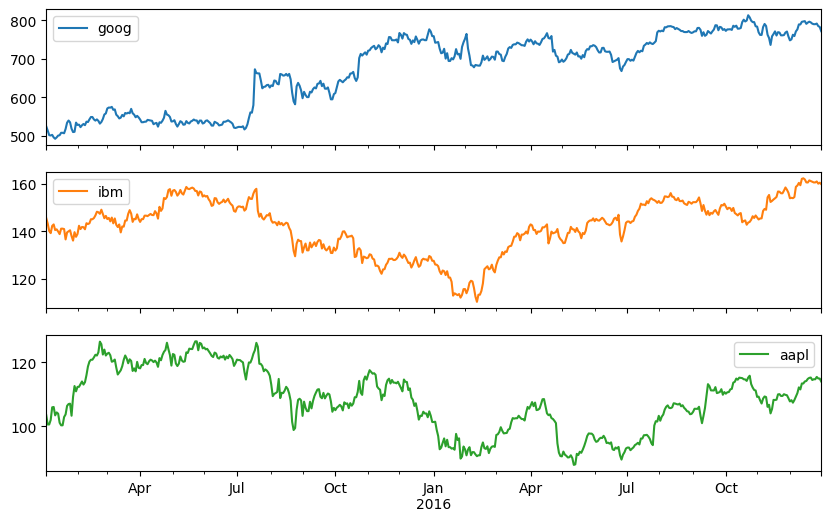

In [142]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad', inplace=True)
df.plot(figsize=(10, 6), subplots=True);

In [143]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


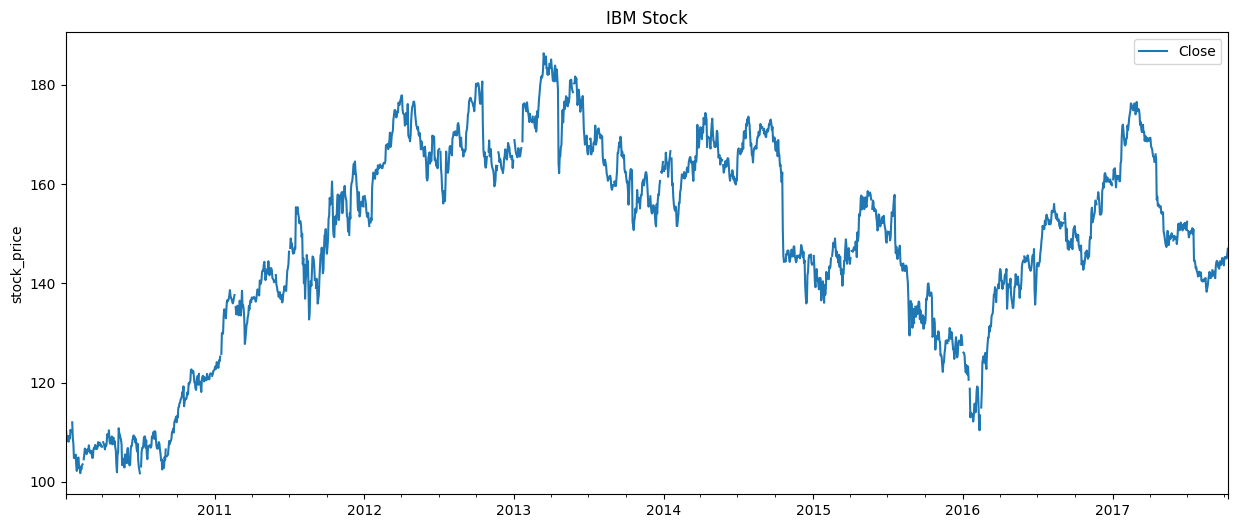

In [144]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("DATA/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [145]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [146]:
#some pre-processing
df_ibm=df_ibm.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))


<ipython-input-146-b8ae6ac2b06d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ibm=df_ibm.fillna(method='ffill')


In [147]:
# function to create train, test data given stock data and sequence length
train_set_size = 123
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [148]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [149]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

## Assingment: Build LSTM
* build a PyTorch LSTM model
* train and evaluate
* plot prediction and true stock valaues

In [150]:
# Build model
#####################
input_dim = 1
hidden_dim = 43
num_layers = 8
output_dim = 1

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.num_classes = output_dim
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_dim
        # LSTM unit -> just one module for the full RNN grid setup!
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Linear(self.hidden_size*self.num_layers, self.num_classes)

    def forward(self, x):
        #init input
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size*num_layers)

        out = self.fc(h_out)

        return out



Using cuda device


In [136]:
num_epochs = 4000
learning_rate = 0.01

lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.24807
Epoch: 100, loss: 0.02153
Epoch: 200, loss: 0.02131
Epoch: 300, loss: 0.05458
Epoch: 400, loss: 0.02064
Epoch: 500, loss: 0.02253
Epoch: 600, loss: 0.02154
Epoch: 700, loss: 0.01911
Epoch: 800, loss: 0.01721
Epoch: 900, loss: 0.01505
Epoch: 1000, loss: 0.01855
Epoch: 1100, loss: 0.01331
Epoch: 1200, loss: 0.01127
Epoch: 1300, loss: 0.00831
Epoch: 1400, loss: 0.00872
Epoch: 1500, loss: 0.00295
Epoch: 1600, loss: 0.00133
Epoch: 1700, loss: 0.00186
Epoch: 1800, loss: 0.00055
Epoch: 1900, loss: 0.00030
Epoch: 2000, loss: 0.00084
Epoch: 2100, loss: 0.00027
Epoch: 2200, loss: 0.00018
Epoch: 2300, loss: 0.00021
Epoch: 2400, loss: 0.00008
Epoch: 2500, loss: 0.00008
Epoch: 2600, loss: 0.00004
Epoch: 2700, loss: 0.00006
Epoch: 2800, loss: 0.00020
Epoch: 2900, loss: 0.00004
Epoch: 3000, loss: 0.00003
Epoch: 3100, loss: 0.00001
Epoch: 3200, loss: 0.00001
Epoch: 3300, loss: 0.00001
Epoch: 3400, loss: 0.00001
Epoch: 3500, loss: 0.00001
Epoch: 3600, loss: 0.00298
Epoch: 3700, 

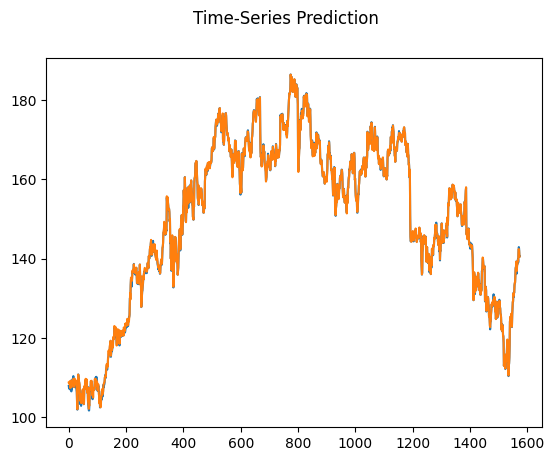

In [137]:
lstm.eval()
train_predict = lstm(x_train)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y_train.cpu().data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

#plt.axvline(x=train_set_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

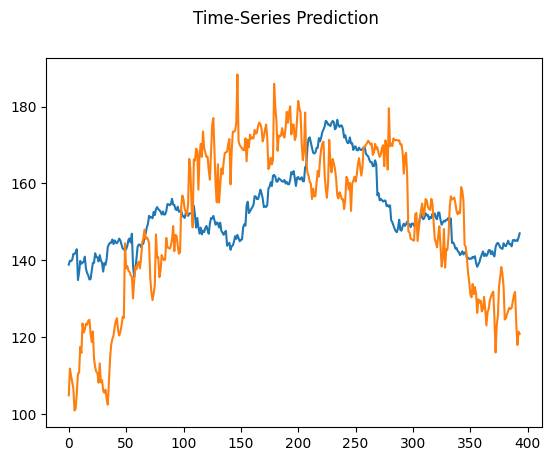

In [138]:
lstm.eval()
train_predict = lstm(x_test)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y_test.cpu().data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

#plt.axvline(x=train_set_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()